# DCGAN 구현

paper : https://arxiv.org/abs/1511.06434
참조 : https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
!nvidia-smi

Mon Dec 27 04:24:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.cuda import is_available
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets
import os
%matplotlib inline

In [ ]:
device='cuda' if is_available() else 'cpu'

In [ ]:

path2data = './data'
os.makedirs(path2data, exist_ok=True)
h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = transforms.Compose([
                    transforms.Resize((h,w)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
])

STL10 dataset 불러오기
https://cs.stanford.edu/~acoates/stl10/

In [ ]:
all_data= datasets.STL10(path2data, split='train', download=True, transform=transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


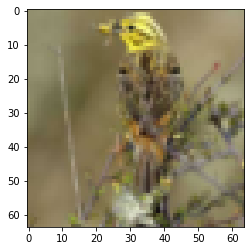

In [ ]:
img, _ = all_data[0]
plt.imshow(to_pil_image(0.5*img+0.5))

DCGAN에선 배치사이즈 128, 학습율 0.0002, leaky ReLU의 경우 0.2를 사용했다.


In [ ]:
batch_size = 128
l_rate = 0.0002
leaky_rate = 0.2

Convolution 가중치는 평균0, 표준편차 0.02로 초기화했고, batch Normalization의 경우, 평균1, 표준편차는 0.02로 초기화했다.

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Generator의 경우, 
- 기존 GAN과 달리 FC는 없앴고,
-  Batch Normalization을 사용했다. 하지만 마지막 Generator의 출력부분에는 사용하지 않는다.
-  마지막 출력은 tanh()함수를 사용한다.
- ReLU함수 사용한다.

In [ ]:
class Generator(nn.Module):
  def __init__(self,num_noises,num_cov,img_channels):
    super().__init__()
    self.nz = num_noises
    self.nc = num_cov
    self.imgc = img_channels
    self.dconv1 = nn.ConvTranspose2d(self.nz,self.nc*8,4,stride=1,padding=0,bias=False)
    self.bn1 = nn.BatchNorm2d(self.nc*8)
    self.dconv2 = nn.ConvTranspose2d(self.nc*8,self.nc*4,4,stride=2,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(self.nc*4)
    self.dconv3 = nn.ConvTranspose2d(self.nc*4,self.nc*2,4,stride=2,padding=1,bias=False)
    self.bn3 = nn.BatchNorm2d(self.nc*2)
    self.dconv4 = nn.ConvTranspose2d(self.nc*2,self.nc,4,stride=2,padding=1,bias=False)
    self.bn4 = nn.BatchNorm2d(self.nc)
    self.dconv5 = nn.ConvTranspose2d(self.nc,self.imgc,4,stride=2,padding=1,bias=False) 
  def forward(self,x):
    x = self.dconv1(x)
    x = F.relu(self.bn1(x))
    x = self.dconv2(x)
    x = F.relu(self.bn2(x))
    x = self.dconv3(x)
    x = F.relu(self.bn3(x))
    x = self.dconv4(x)
    x = F.relu(self.bn4(x))
    x = self.dconv5(x)
    x = torch.tanh(x)
    return x
    

In [ ]:
x = torch.randn(1,100,1,1, device=device)
model_gen = Generator(100,64,3).to(device)
out_gen = model_gen(x)
print(out_gen.shape)

torch.Size([1, 3, 64, 64])


Discriminator의 경우,
- Leaky ReLU에 0.2를 줘서 사용한다.
- 마찬가지로 BatchNormalization을 사용하는데, 입력 부분에선 사용하지 않는다.
- FC가 없다.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,num_cov,img_channels,leaky_rate):
    super().__init__()
    self.nc = num_cov
    self.lk = leaky_rate
    self.imgc = img_channels
    self.conv1 = nn.Conv2d(self.imgc,self.nc,4,stride=2,padding=1,bias=False )
    self.conv2 = nn.Conv2d(self.nc,self.nc*2,4,stride=2,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(self.nc*2)
    self.conv3 = nn.Conv2d(self.nc*2,self.nc*4,4,stride=2,padding=1,bias=False)
    self.bn3 = nn.BatchNorm2d(self.nc*4)
    self.conv4 = nn.Conv2d(self.nc*4,self.nc*8,4,stride=2,padding=1,bias=False)
    self.bn4 = nn.BatchNorm2d(self.nc*8)
    self.conv5 = nn.Conv2d(self.nc*8,1,4,1,0,bias=False)
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = F.leaky_relu(self.bn2(x),self.lk)
    x = self.conv3(x)
    x = F.leaky_relu(self.bn3(x),self.lk)
    x = self.conv4(x)
    x = F.leaky_relu(self.bn4(x),self.lk)
    x = self.conv5(x)
    x = torch.sigmoid(x)
    return x.view(-1,1)





In [ ]:
x = torch.randn(16,3,64,64,device=device)
model_dis = Discriminator(64,3,leaky_rate).to(device)
out_dis = model_dis(x)
print(out_dis.shape)

torch.Size([16, 1])


In [ ]:
model_gen.apply(weights_init_normal)
model_dis.apply(weights_init_normal)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

generator와 discriminator의 optimizer는 따로 계산한다. 둘다 Adam을 사용했고 둘다 BCELoss를 사용해서 오차를 구한다.


In [ ]:
from torch import optim
beta1 = 0.5
beta2 = 0.999

optD = optim.Adam(model_dis.parameters(),lr=l_rate,betas=(beta1,beta2))
optG = optim.Adam(model_gen.parameters(),lr=l_rate,betas=(beta1,beta2))

criterion = nn.BCELoss()

In [ ]:
model_gen.train()
model_dis.train()

batch_count=0
num_epochs=100
loss_hist = {'d_loss':[],
             'g_loss':[]}


In [ ]:
train= DataLoader(all_data, batch_size=batch_size, shuffle=True)

In [ ]:
import torchvision.utils as vutils

학습 시 
1. 먼저 generator로 생성한 가짜 이미지를 discriminator가 판별하여 그 값을 이용해 g_loss를 구한다.
2. discriminator는 가짜이미지와 진짜이미지를 통해 학습한다. 

Epoch: 0, G_Loss: 2.937, D_Loss: 0.205


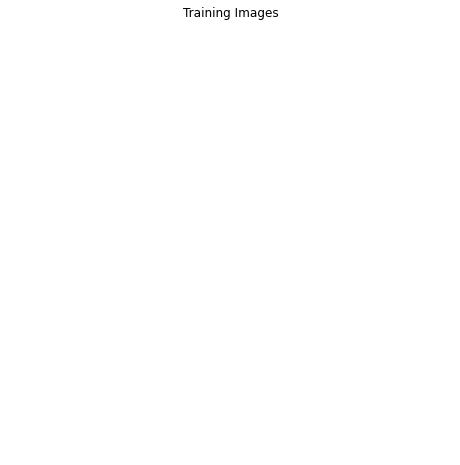

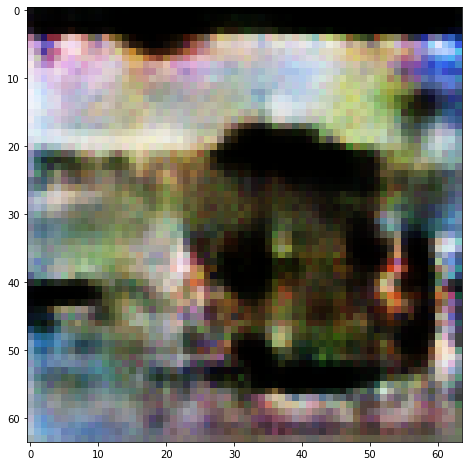

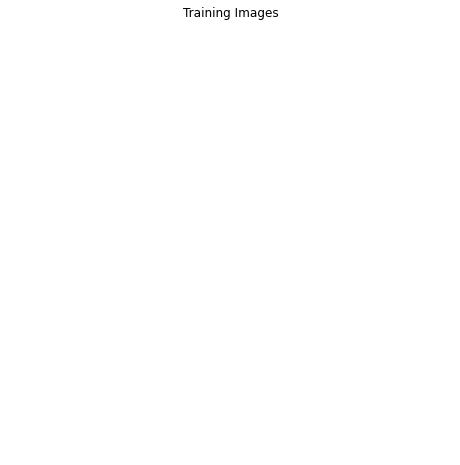

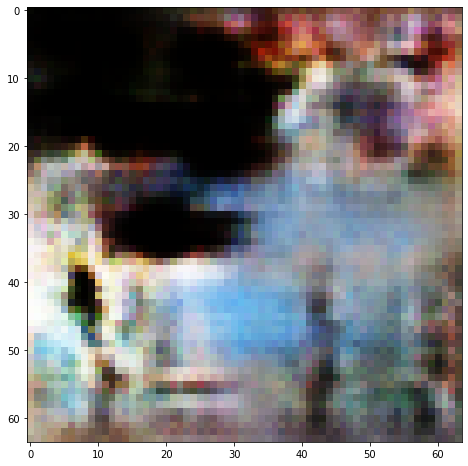

Epoch: 2, G_Loss: 2.342, D_Loss: 0.175


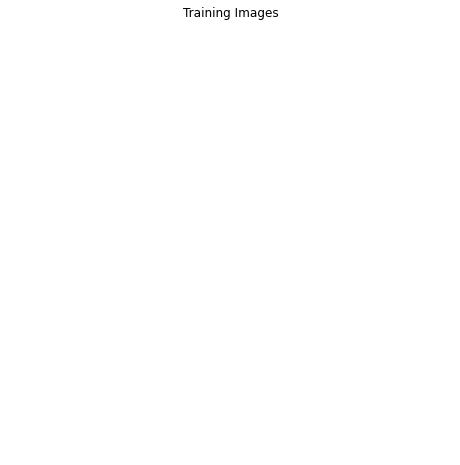

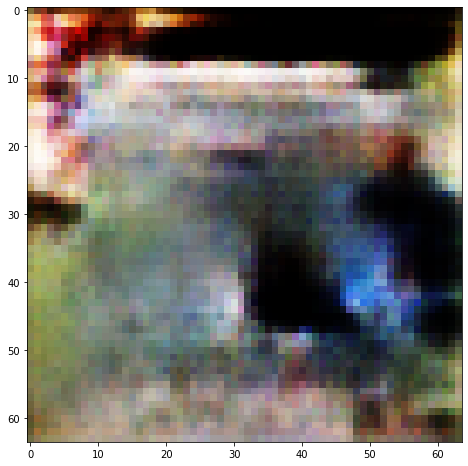

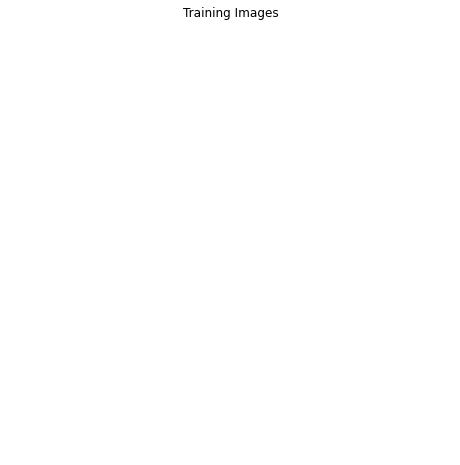

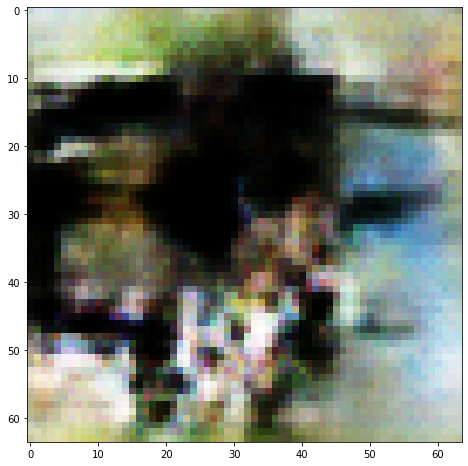

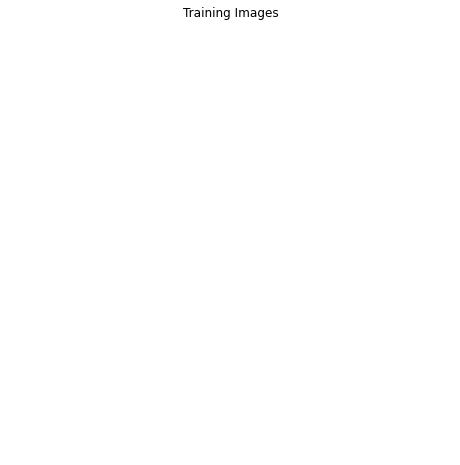

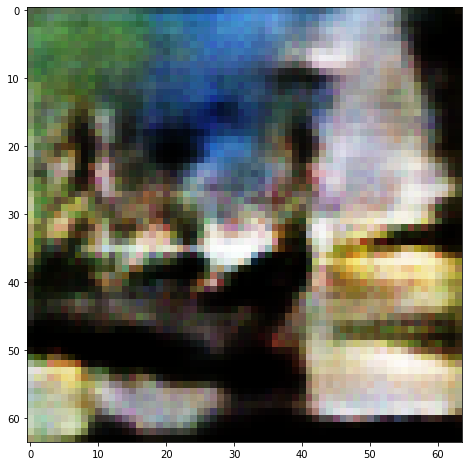

Epoch: 5, G_Loss: 1.458, D_Loss: 0.392


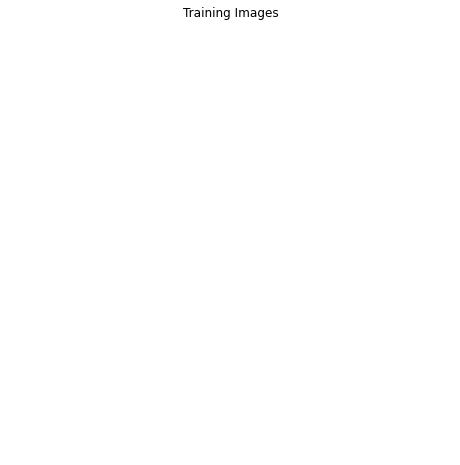

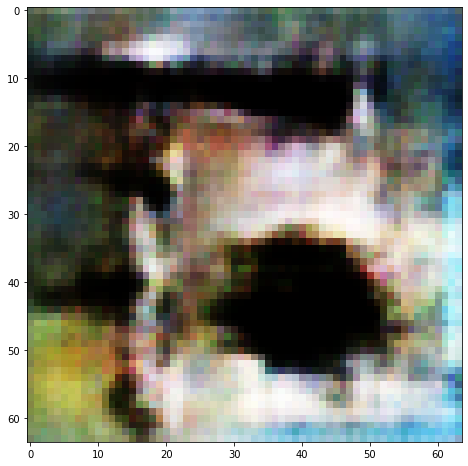

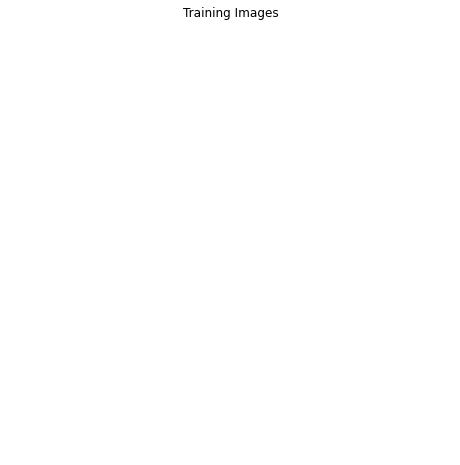

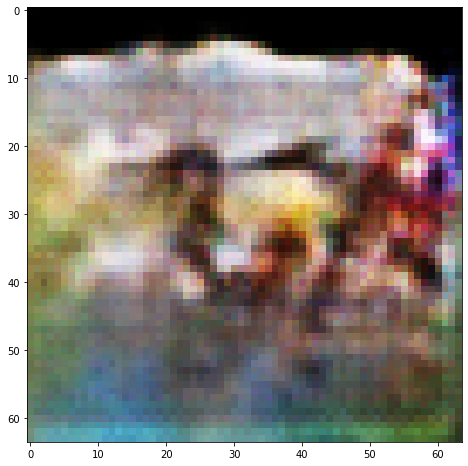

Epoch: 7, G_Loss: 2.766, D_Loss: 0.181


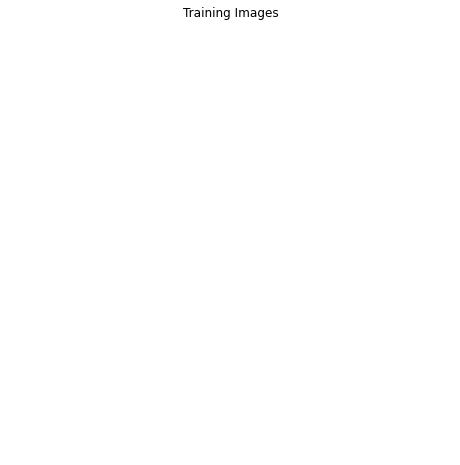

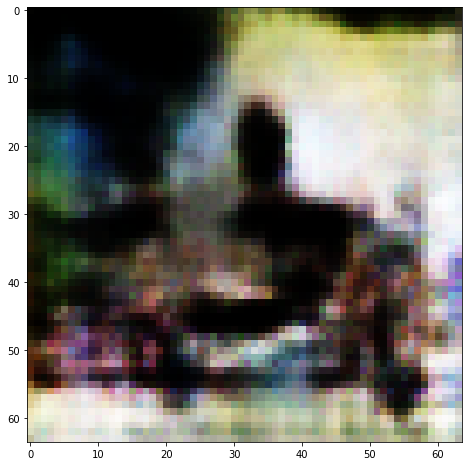

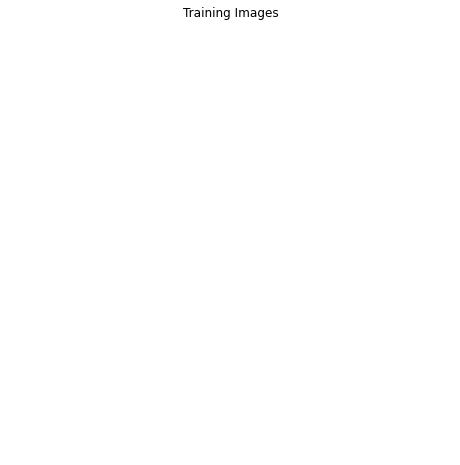

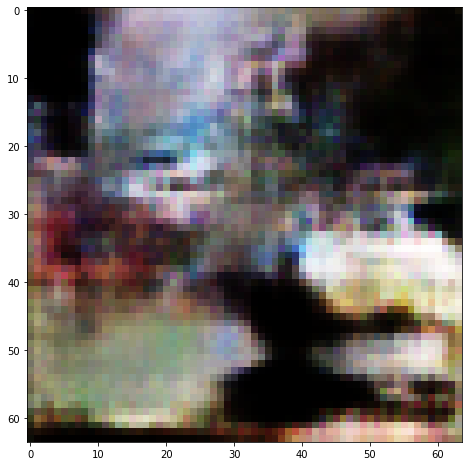

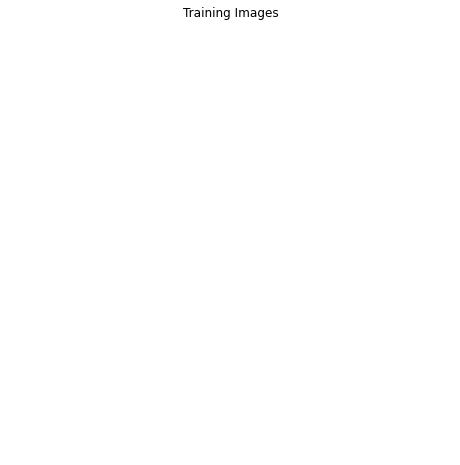

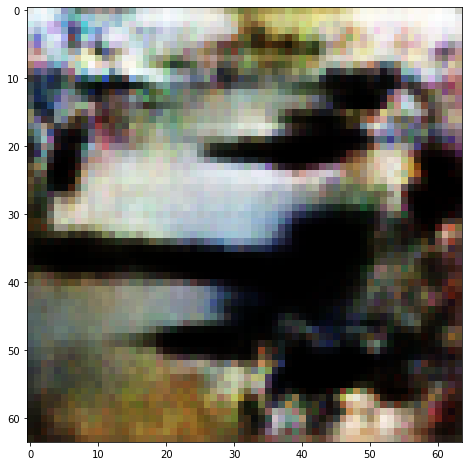

Epoch: 10, G_Loss: 1.199, D_Loss: 0.448


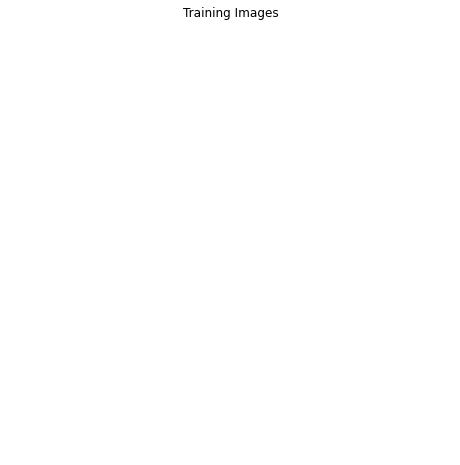

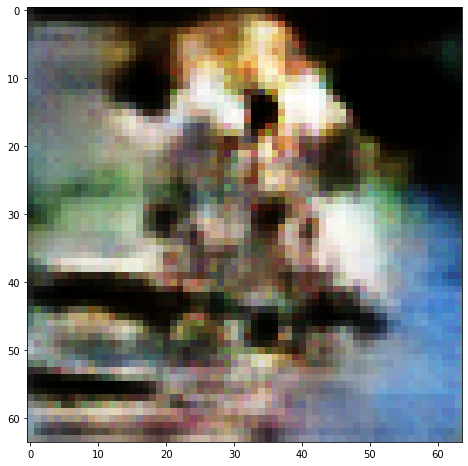

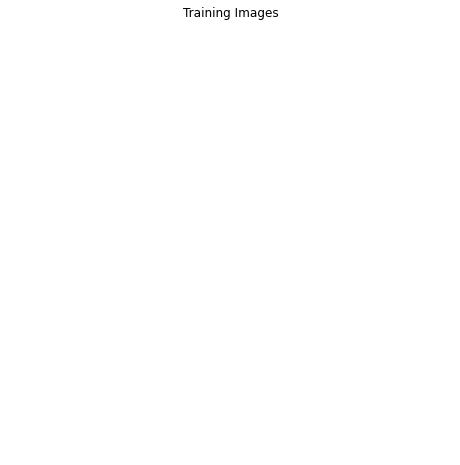

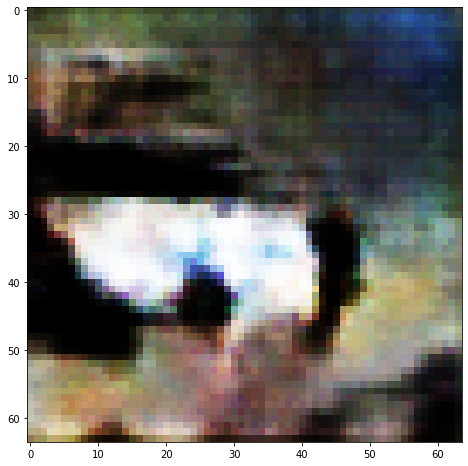

Epoch: 12, G_Loss: 2.378, D_Loss: 0.181


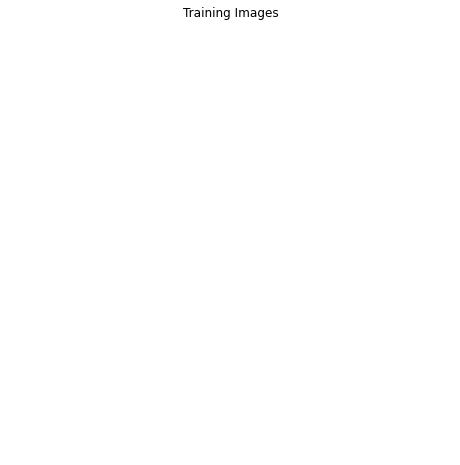

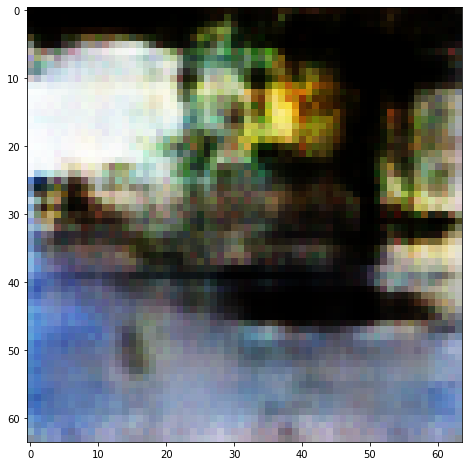

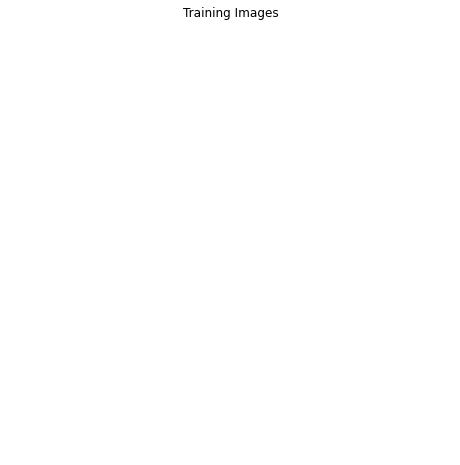

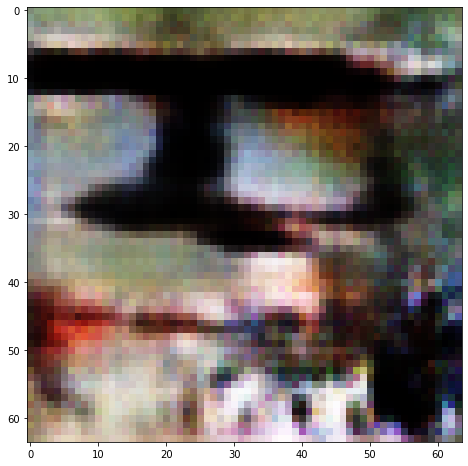

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(num_epochs):
    for x, y in train:
        batch_size = x.shape[0]
        img_size = x.shape[1]
        x = x.to(device)
        y_real = torch.Tensor(batch_size,1).fill_(1.0).to(device)
        y_fake = torch.Tensor(batch_size,1).fill_(0.0).to(device)

        model_gen.zero_grad()

        z = torch.randn(batch_size,100,1,1).to(device) 
        out_gen = model_gen(z) 
        outD = model_dis(out_gen)

        g_loss = criterion(outD,y_real)
        g_loss.backward()
        optG.step()

        # discriminator
        model_dis.zero_grad()
        
        out_dis = model_dis(x) # 진짜 이미지 식별
        loss_real = criterion(out_dis,y_real)

        out_dis = model_dis(out_gen.detach()) # 가짜 이미지 식별
        loss_fake = criterion(out_dis,y_fake)

        d_loss = (loss_real + loss_fake) / 2
        d_loss.backward()
        optD.step()

        loss_hist['g_loss'].append(g_loss.item())
        loss_hist['d_loss'].append(d_loss.item())

        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %d, G_Loss: %.3f, D_Loss: %.3f' %(epoch, g_loss.item(), d_loss.item())
          )
    noise=torch.randn(1,100,1,1).to(device)
    fake = model_gen(noise)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.figure(figsize=(8,8))
    image = np.transpose(vutils.make_grid(fake.detach()[:64], padding=2, normalize=True).cpu(), (1,2,0))
    plt.imshow(image)
    plt.show()